## Import Modules

In [1]:
import numpy as np
import sys
from casadi import *

import do_mpc
import warnings
warnings.filterwarnings("ignore")

In [2]:
model_type = 'continuous' 
model = do_mpc.model.Model(model_type)

## Parameters
Bicycle model with the following parameters is used for ego vehicle:

- m is the total vehicle mass (kg).

- Iz is the yaw moment of inertia of the vehicle (Kg*m^2).

- lf is the longitudinal distance from the center of gravity to the front tires (m).

- lr is the longitudinal distance from center of gravity to the rear tires (m).

- Cf is the cornering stiffness of the front tires (N/rad).

- Cr is the cornering stiffness of the rear tires (N/rad).

- Vx is the longitudinal Velocity (m/s) (Assumed to be constant).

- Ts is the sampling time (s).

- PredicitonHorizon is the prediction horizon for MPC.

- Time is the simulation time (15 s)

In [3]:
m = 1575  
Iz = 2875 
lf = 1.2  
lr = 1.6  
Cf = 19000 
Cr = 33000 

Vx=15 
Ts = 0.1  
PredictionHorizon = 10 
Time = np.arange(0, 15, Ts)  

## Model Variables
**State Variables**:
- Vy is the lateral velocity (m/s)
- r is the yaw angle rate (rad/s)
- e1 is the relative yaw angle (rad)
- e2 is the lateral deviation (m)
- st_angle is the steering angle (rad)
- rho is the curvature (1/m)

In [4]:
Vy = model.set_variable('_x',  'Vy')
r = model.set_variable('_x',  'r')
e1=model.set_variable(var_type='_x', var_name='e1')
e2=model.set_variable(var_type='_x', var_name='e2')
st_angle=model.set_variable('_u',  'st_angle')
rho=model.set_variable('_tvp', 'rho') #Curvature

## State-Space Model 

In [5]:
A = np.array([
    [-(2*Cf + 2*Cr)/(m * Vx), (2*Cf*lf - 2*Cr*lr)/(m * Vx)],
    [(2*Cf*lf - 2*Cr*lr)/(Iz * Vx), -(2*Cf*lf**2 + 2*Cr*lr**2)/(Iz * Vx)]
])

B = np.array([
    [2*Cf/m],
    [2*Cf*lf/Iz]
])
states=vertcat(Vy,r)
inputs=vertcat(st_angle)
dx = A @ states + B @ inputs

## Dynamics of relative yaw angle and lateral deviation

In [6]:
dot_e1 = (Vx * e2) + Vy
dot_e2 = r - (Vx * rho)

## Right-hand-side equation

In [7]:
model.set_rhs('Vy', dx[0])
model.set_rhs('r', dx[1])
model.set_rhs('e1', dot_e1)
model.set_rhs('e2', dot_e2)

In [8]:
model.setup()

## Generate Curvature

In [9]:
def get_curvature(Vx, time):
    Xref = Vx * time
    
    z1 = (2.4 / 50) * (Xref - 27.19) - 1.2
    z2 = (2.4 / 43.9) * (Xref - 56.46) - 1.2
    Yref = 8.1 / 2 * (1 + np.tanh(z1)) - 11.4 / 2 * (1 + np.tanh(z2))
    
    # Compute gradients
    DX = np.gradient(Xref, 0.1)   
    DY = np.gradient(Yref, 0.1)   
    D2Y = np.gradient(DY, 0.1)    
    
    curvature = (DX * D2Y) / ((DX**2 + DY**2)**(3 / 2))
    
    return curvature

In [10]:
curvature_profile = get_curvature(Vx, np.arange(0, 15, 0.1))

## Simulator 

In [11]:
simulator = do_mpc.simulator.Simulator(model)

In [12]:
tvp_template_sim = simulator.get_tvp_template()

In [13]:
def tvp_fun_sim(t_now):
    tvp_template_sim['rho'] = curvature_profile[int(t_now / Ts)]
    return tvp_template_sim

In [14]:
simulator.set_tvp_fun(tvp_fun_sim)

In [15]:
params_simulator = {
    'integration_tool': 'idas',
    'abstol': 1e-8,
    'reltol': 1e-8,
    't_step': Ts
}

simulator.set_param(**params_simulator)

In [16]:
simulator.setup()

In [17]:
simulator.x0['Vy']=0
simulator.x0['r']=0
simulator.x0['e1']=0
simulator.x0['e2']=0
x0 = simulator.x0.cat.full()
simulator.set_initial_guess()

## MPC

In [18]:
mpc = do_mpc.controller.MPC(model)

In [19]:
setup_mpc = {
    'n_horizon': PredictionHorizon,
    'n_robust': 0,
    'open_loop': 0,
    't_step': Ts,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 3,
    'collocation_ni': 1,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps'}
}
mpc.set_param(**setup_mpc)

In [20]:
tvp_template_mpc=mpc.get_tvp_template()

In [21]:
def tvp_fun_mpc(t_now):
    for k in range(PredictionHorizon+1):
        tvp_template_mpc['_tvp',k,'rho']=curvature_profile[int(t_now / Ts)]
    return tvp_template_mpc

In [22]:
mpc.set_tvp_fun(tvp_fun_mpc)

In [23]:
mterm =e1**2+e2**2
lterm=mterm
mpc.set_objective(mterm=mterm, lterm=lterm)

mpc.set_rterm(st_angle=0.1)

In [24]:
mpc.bounds['lower','_u','st_angle'] = -0.5
mpc.bounds['upper','_u','st_angle'] = 0.5

In [25]:
mpc.setup()

In [26]:
estimator = do_mpc.estimator.StateFeedback(model)

In [27]:
mpc.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

## Plots Setup

In [28]:
%%capture
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.size'] = 14
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.grid'] = True

mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

fig, ax = plt.subplots(3, sharex=True, figsize=(12, 9))  # Adjust figsize for better aspect ratio

for g in [sim_graphics, mpc_graphics]:
    g.add_line(var_type='_x', var_name='e2', axis=ax[0])  # Lateral deviation
    g.add_line(var_type='_x', var_name='e1', axis=ax[1])  # Relative yaw rate
    g.add_line(var_type='_u', var_name='st_angle', axis=ax[2])  # Steering angle

ax[0].set_ylabel('Lateral deviation (m)')
ax[1].set_ylabel('Relative yaw angle (rad)')
ax[2].set_ylabel('Steering angle (rad)')
ax[2].set_xlabel('Time (s)')

ax[0].set_title('Lateral deviation')
ax[1].set_title('Relative yaw angle')
ax[2].set_title('Steering angle')

fig.align_ylabels()

plt.tight_layout()

plt.show()

In [29]:
u0 = mpc.make_step(x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:      854
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       41

Total number of variables............................:      230
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:      204
Total number of inequality c

In [30]:
sim_graphics.clear()

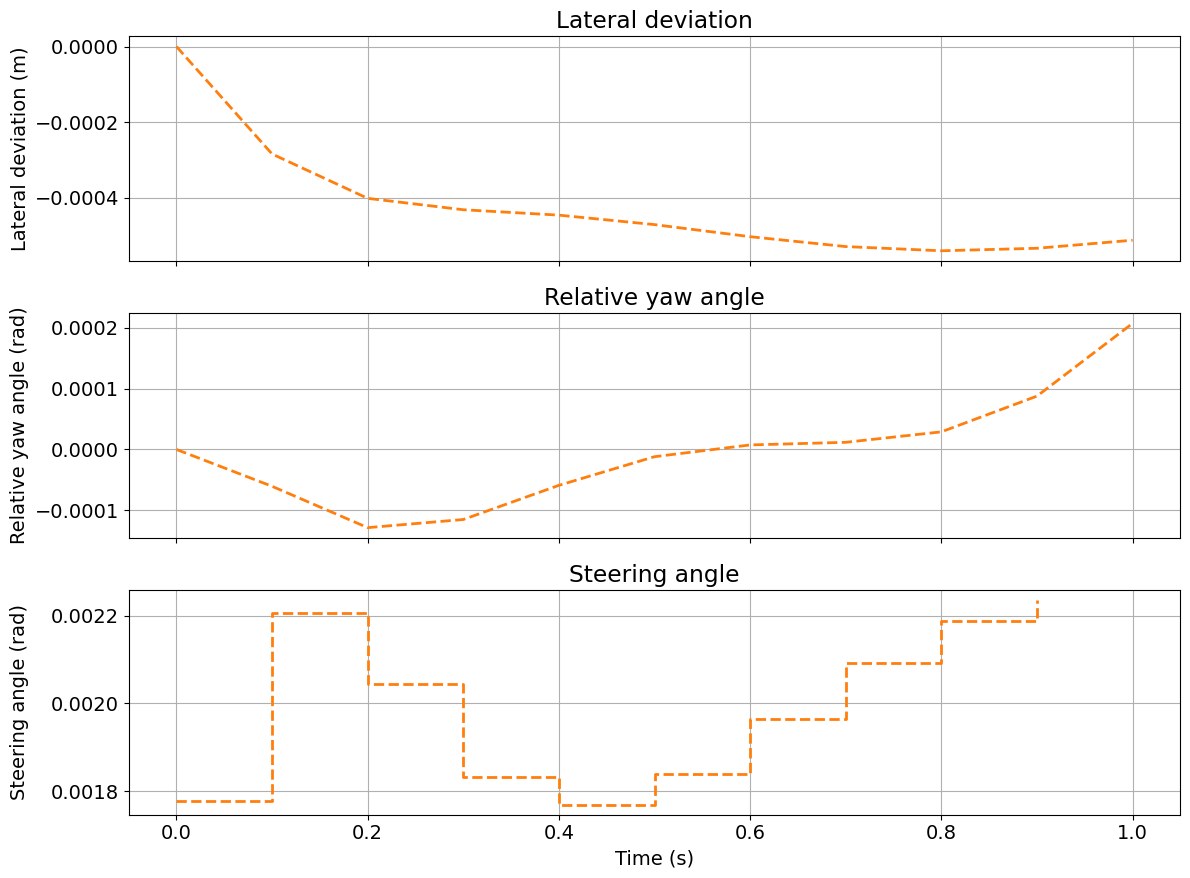

In [31]:
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
# Show the figure:
fig

In [32]:
%%capture
# Quickly reset the history of the MPC data object.
import time
start_time = time.time()

mpc.reset_history()
simulator.reset_history()

for k in range(len(Time)):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)
end_time = time.time()

In [33]:
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 0.9823017120361328 seconds


## Final Results
- As can be seen that the lateral deviation and the relative yaw angle both converge to zero. So, the ego car follows the road closely based on the curvature.

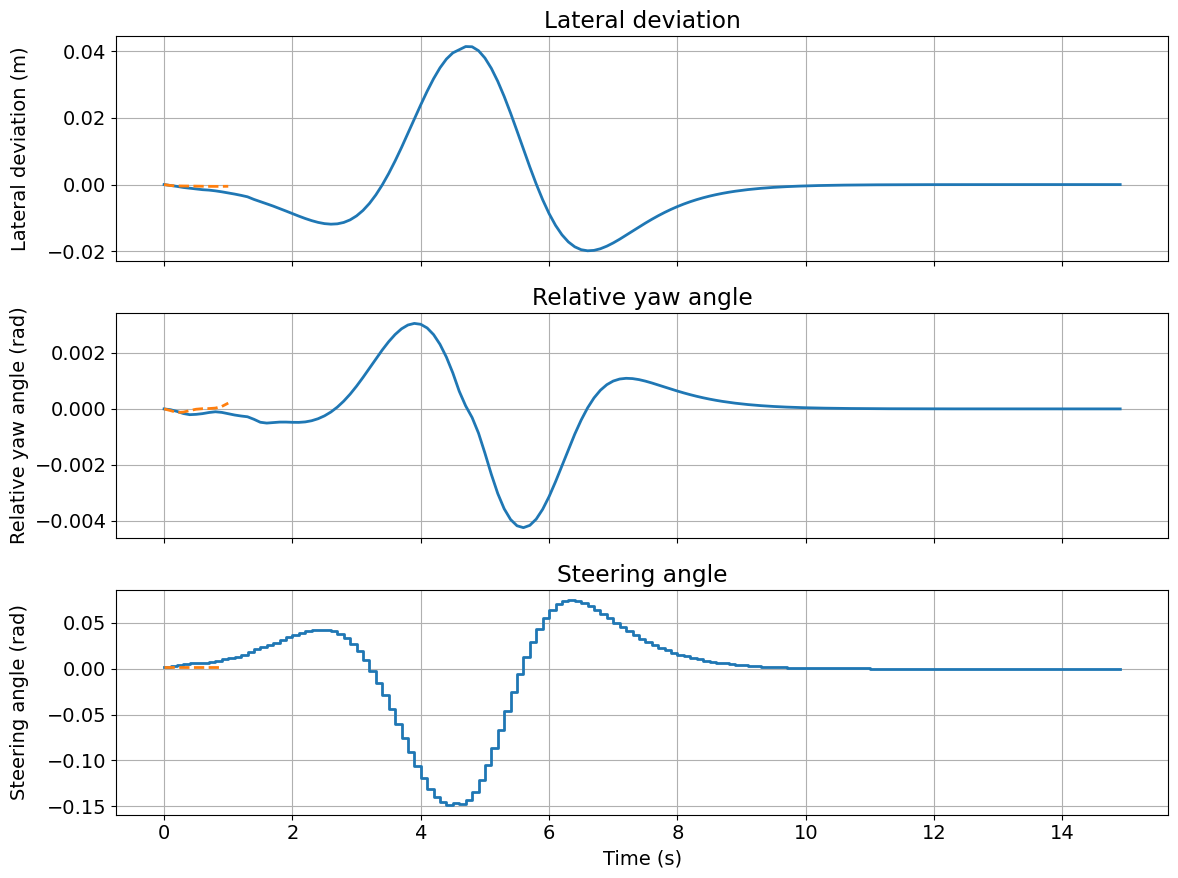

In [34]:
sim_graphics.plot_results()
sim_graphics.reset_axes()
fig